# Guassian Processes (GP) for Epoxy Resin Degree of Cure
Using same training data, the mean value and variance of resin properties at test points are predicted through using GP processes

In [40]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn as sk
import scipy as sp

### Inputs 
Material properties, data information, and processing parameters

In [41]:
n = 100 # number of data points
test_size = 0.3 # test data size ratio
Type = 'ConstRate' # Iso, ConstRate, OneHold

ts = 0 # start time, min
te = 90 # end time, min

# Isothermal
T_iso = 140+273 # Temp for isotermal process

# Dynamic _ Constant Rate
Tr = 3 # Temp rate for dynamic process, K/min
Ts = 293 # start temp, K

# Dynamic _ One Hold
th1 = 52 # hold start time, min
th2 = 172 # hold end time, min
Tsh = 293 # start temp, K
Th = 453 # hold temp, K

### Functions 

In [15]:
# Temperature function, Dynamic _ Constant Rate
def Temp_constrate(t,T_start,T_rate):
    Temp = t*T_rate + T_start
    return Temp 

# Temperature function, Dynamic _ One Hold
def Temp_onehold(t,th1,th2,Tsh,Th):
    T_rate = (Th-Tsh) / th1
    
    if t < th1:
        Temp = t*T_rate + Tsh
    elif t > th2:
         Temp = -(t-th2)*T_rate + Th
    else:
         Temp = Th
         
    return Temp
    
# C Coefficients in material model
def C(Temp):
    C = list(range(3))
    for i in range(3):
        C[i]= A[i] * np.exp(-dE[i]/(R*Temp))
    return C

# Rate of degree of cure function (refer to paper)
def X_rate(x,T):
    if x <= 0.3:
        xr = (C(T)[0]+(C(T)[1]*x)) * (1-x) * (B-x)
    else:
        xr = C(T)[2]*(1-x) 
    return xr

### Data 
Gnerating data based on material model for training

In [42]:
# Table 5.2 of S.A. Niaki Thesis for 3501-6
A1 = 3.5017e7
A2 = -3.3567e7
A3 = 3.2667e3
A = [A1, A2, A3]
dE1 = 80700
dE2 = 77800
dE3 = 56600
dE = [dE1, dE2, dE3]
B = 0.47
R = 8.314

time = np.linspace(start=ts, stop=te, num=n)
dt = (te-ts)/n * 60
X = [0] * (n+1)
Xr = [0] * n
T_list = [0] * n


for i in range(len(time)):
    t = time[i]
    if Type == 'Iso':
        T = T_iso
    elif Type == 'ConstRate':
        T = Temp_constrate(t,Ts,Tr)
    else:
        T = Temp_onehold(t,th1,th2,Ts,Th)
    
    T_list[i] = T
    Xr[i] =  X_rate(X[i],T)
    X[i+1] = X[i] + dt * Xr[i]
X.pop()

# Adding noise to data
#sigma_n = min(Xr)/10
#epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
#Xr = Xr + epsilon

Xr = [-i if i <= 0 else i for i in Xr]

#### Data Visualization

Text(0, 0.5, 'Temp')

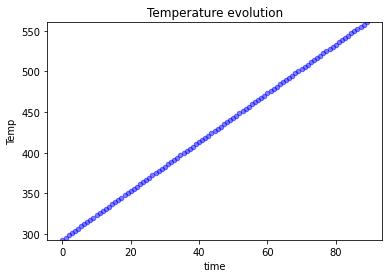

In [43]:
plt.subplot(111)
plt.scatter(time[:-1], T_list[:-1], color='blue', s = 20, alpha = 0.5)
plt.ylim(min(T_list[:-1]), max(T_list[:-1]))
plt.title('Temperature evolution')
plt.xlabel('time')
plt.ylabel('Temp')

Text(0, 0.5, 'Degree of cure')

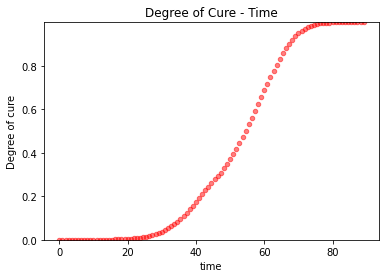

In [44]:
plt.subplot(111)
plt.scatter(time[:-1], X[:-1], color='red', s = 20, alpha = 0.5)
plt.ylim(min(X[:-1]), max(X[:-1]))
plt.title('Degree of Cure - Time')
plt.xlabel('time')
plt.ylabel('Degree of cure')

Text(0, 0.5, 'Rate of cure')

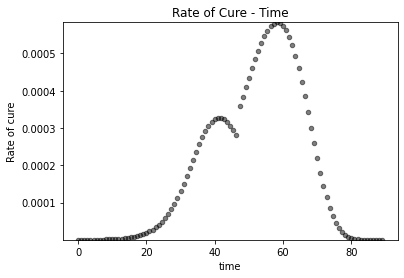

In [45]:
plt.subplot(111)
plt.scatter(time[:-1], Xr[:-1], color='black', s = 20, alpha = 0.5)
plt.ylim(min(Xr[:-1]), max(Xr[:-1]))
plt.title('Rate of Cure - Time')
plt.xlabel('time')
plt.ylabel('Rate of cure')

In [46]:
# plt.subplot(111)
# plt.scatter(T_list[:-1], Xr[:-1], color='blue', s = 20, alpha = 0.5)
# plt.ylim(min(Xr[:-1]), max(Xr[:-1]))
# plt.xlabel('Temp')
# plt.ylabel('Rate of cure')

In [47]:
# plt.subplot(111)
# plt.scatter(X[:-1], Xr[:-1], color='blue', s = 20, alpha = 0.5)
# plt.ylim(min(Xr[:-1]), max(Xr[:-1]))
# plt.xlabel('Degree of cure')
# plt.ylabel('Rate of cure')

In [48]:
# plt.subplot(111)
# plt.scatter(T_list[:-1], np.log(Xr[:-1]), color='blue', s = 20, alpha = 0.5)
# plt.ylim(min(np.log(Xr[:-1])), max(np.log(Xr[:-1])))
# plt.xlabel('Temp')
# plt.ylabel('Ln of rate of cure')

In [49]:
# Data preprocessing
x = [[T_list[i],X[i]] for i in range(len(T_list))]
y = [i for i in np.log(Xr)]

# feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x= sc_X.fit_transform(x)

# Training and Test data
from sklearn.model_selection import train_test_split
x1, x2, y1, y2 = train_test_split(x, y, test_size = test_size)


''' Least square optimization '''
from scipy.optimize import leastsq

def func(params, xdata, ydata):
    return (ydata - (params[0]-params[1]/xdata))


x0 = np.ones(2)
x_arr = np.array([i[0] for i in x1])
y_arr = np.array(y1)

params = leastsq(func, x0, args=(x_arr, y_arr))
params_lst = params[0].tolist()

In [52]:
# # Visualization
# plt.subplot(111)
# plt.scatter(x_arr, y_arr, color='blue', s = 20, alpha = 0.5, label='sample data')
# plt.scatter(x_arr, params_lst[0]-params_lst[1]/x_arr, color='red', s = 20, alpha = 0.5)
# plt.ylim(min(y_arr), max(y_arr))
# plt.xlabel('Temp')
# plt.ylabel('log of rate of cure')

In [53]:
# plt.subplot(111)
# plt.scatter(x_arr, np.exp(y_arr), color='blue', s = 20, alpha = 0.5, label='sample data')
# plt.scatter(x_arr, np.exp(params_lst[0]-params_lst[1]/x_arr), color='red', s = 20, alpha = 0.5)
# plt.ylim(min(np.exp(y_arr)), max(np.exp(y_arr)))
# plt.xlabel('Temp')
# plt.ylabel('Rate of cure')

### Gaussian processes

In [54]:
'''functions'''
def Euc_dic(x,y):
    dis = [(x[i]-y[i])**2  for i in list(range(np.shape(x)[0]))]
    return np.sqrt(sum(dis))

def kernel(x1, x2, sigma):
    krnl = np.array([np.exp(-1/(2*(sigma**2))*Euc_dic(i,j)**2)  for i in x1 for j in x2])
    krnl = krnl.reshape(len(x1), len(x2))
    return krnl

def cov(x1, x2, sigma):
    sig11 = kernel(x1, x1, sigma)
    sig12 = kernel(x1, x2, sigma)
    sig21 = kernel(x2, x1, sigma)
    sig22 = kernel(x2, x2, sigma)
    cov_mat1 = np.concatenate((sig11, sig12), axis=1)
    cov_mat2 = np.concatenate((sig21, sig22), axis=1)
    cov_mat = np.concatenate((cov_mat1, cov_mat2), axis=0)
    return cov_mat, sig11, sig12, sig21, sig22

def prior_mu(vec):
    A= params_lst[0]
    B= params_lst[1]
    pr_mean = [(A - B / j) for j in [i[0] for i in vec]] 
    return pr_mean

# prior means and posterior cov
sigma = 0.1
prior_mean1 = prior_mu(x1)
prior_mean2 = prior_mu(x2)
cov_mat, sig11, sig12, sig21, sig22 = cov(x1, x2, sigma)

# cholesky algorithm
L =np.linalg.cholesky(sig11)
alpha = np.linalg.solve(np.transpose(L),(np.linalg.solve(L,y1)))
# posterior predective mean
posterior_mean2 = np.dot(np.transpose(sig12),alpha)
# posterior variance
v2 = np.linalg.solve(L,sig12)
posterior_var2 = sig22 - np.dot(np.transpose(v2),v2)


# Backscaling
x1 = sc_X.inverse_transform(x1)
x2 = sc_X.inverse_transform(x2)
 
# Sorting
z = [x for _, x in sorted(zip(np.array([i[0] for i in x2]), posterior_mean2) )] 
posterior_mean2_srt = np.array(z)

#### Mean value predictions 
Predicting degree of cure mean value at test points

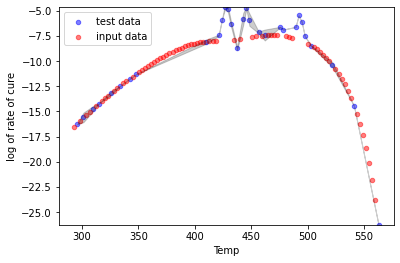

In [55]:
plt.subplot(111)
plt.scatter(np.array([i[0] for i in x2]), posterior_mean2, color='blue', s = 20, alpha = 0.5, label='test data')
plt.scatter(np.array([i[0] for i in x1]), y1, color='red', s = 20, alpha = 0.5, label='input data')
plt.fill_between(np.sort(np.array([i[0] for i in x2])), posterior_mean2_srt - np.diagonal(posterior_var2), posterior_mean2_srt +  np.diagonal(posterior_var2), alpha=0.2, color='k')
plt.ylim(min(min(y1),min(posterior_mean2)), max(max(y1),max(posterior_mean2)))
plt.xlabel('Temp')
plt.ylabel('log of rate of cure')
plt.legend()

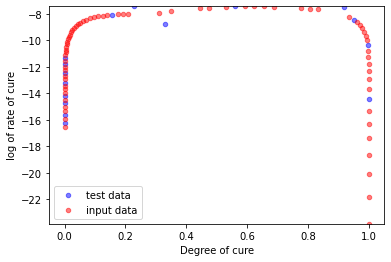

In [56]:
plt.subplot(111)
plt.scatter(np.array([i[1] for i in x2]), posterior_mean2, color='blue', s = 20, alpha = 0.5, label='test data')
plt.scatter(np.array([i[1] for i in x1]), y1, color='red', s = 20, alpha = 0.5, label='input data')
plt.ylim(min(y1), max(y1))
plt.xlabel('Degree of cure')
plt.ylabel('log of rate of cure')
plt.legend()

#### Uncertainty at  test points
Predicting uncertainty in degree of cure at test points

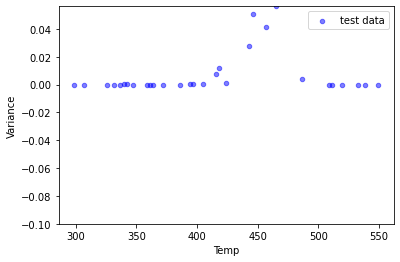

In [39]:
plt.subplot(111)
plt.scatter(np.array([i[0] for i in x2]), np.diag(posterior_var2), color='blue', s = 20, alpha = 0.5, label='test data')
plt.ylim(-0.1, max(np.diag(posterior_var2)))
plt.xlabel('Temp')
plt.ylabel('Variance')
plt.legend()

In [35]:
# plt.subplot(111)
# plt.scatter(np.array([i[0] for i in x2]), np.exp(posterior_mean2), color='blue', s = 20, alpha = 0.5, label='sample data')
# plt.scatter(np.array([i[0] for i in x1]), np.exp(y1), color='red', s = 20, alpha = 0.5, label='predictions')
# plt.ylim(min(np.exp(y1)), max(np.exp(y1)))
# plt.xlabel('Temp')
# plt.ylabel('Rate of cure')
# plt.legend()

In [36]:
# plt.subplot(111)
# plt.scatter(np.array([i[1] for i in x2]), np.exp(posterior_mean2), color='blue', s = 20, alpha = 0.5, label='sample data')
# plt.scatter(np.array([i[1] for i in x1]), np.exp(y1), color='red', s = 20, alpha = 0.5)
# plt.ylim(min(np.exp(y1)), max(np.exp(y1)))
# plt.xlabel('Degree of cure')
# plt.ylabel('Rate of cure')